# Global Terrorism Database EDA
**Exploratory analysis of the Global Terrorism Database with simplified choropleth mapping.**

## Load the dataset

In [1]:
import os

import kagglehub
import matplotlib.pyplot as plt
import pandas as pd

# Download the latest version of GTD dataset
path = kagglehub.dataset_download("START-UMD/gtd")
print("Path to dataset files:", path)

# Load data
csv_file = "globalterrorismdb_0718dist.csv"
df = pd.read_csv(os.path.join(path, csv_file), encoding='latin1', low_memory=False)

# Parse date column
df['date'] = pd.to_datetime(dict(year=df['iyear'], month=df['imonth'], day=df['iday']), errors='coerce')

# Dataset overview
print(f"Dataset shape: {df.shape}")
df.head()

Path to dataset files: C:\Users\aghinea\.cache\kagglehub\datasets\START-UMD\gtd\versions\3
Dataset shape: (181691, 136)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,date
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,1970-07-02
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,NaT
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaT
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaT
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaT


## Data Summary
Overview of key columns and missing values.

In [2]:
summary = df[['iyear', 'country_txt', 'region_txt', 'attacktype1_txt', 'nkill', 'nwound']].isnull().sum().to_frame(
    'missing')
summary['dtype'] = [df[col].dtype for col in summary.index]
summary

,missing,dtype
iyear,0,int64
country_txt,0,object
region_txt,0,object
attacktype1_txt,0,object
nkill,10313,float64
nwound,16311,float64


## Results

### Number of Terrorist Attacks per Year

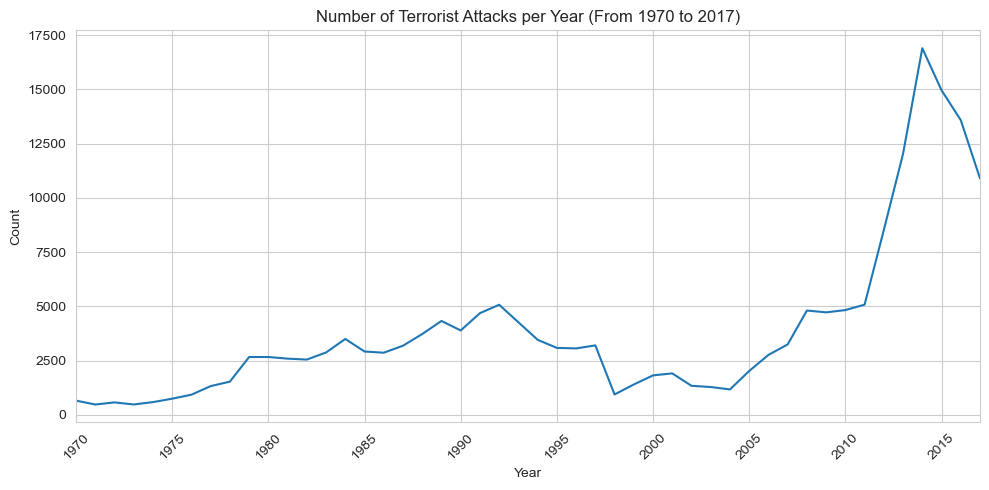

In [3]:
min_year = int(df['iyear'].min())
max_year = int(df['iyear'].max())
attacks_per_year = df.groupby('iyear').size().rename('attacks')

plt.figure(figsize=(10, 5))
attacks_per_year.plot()
plt.title(f'Number of Terrorist Attacks per Year (From {min_year} to {max_year})')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xlim(min_year, max_year)
plt.xticks(range(min_year, max_year + 1, 5), rotation=45)
plt.tight_layout()
plt.show()

### Correlation between Attacks and Fatalities per Year

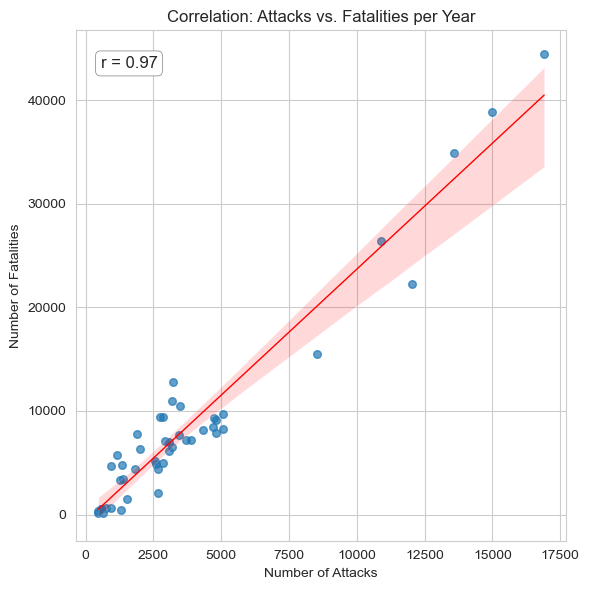

In [4]:
import seaborn as sns

attacks_per_year = df.groupby('iyear').size().rename('attacks')
fatalities_per_year = df.groupby('iyear')['nkill'].sum().rename('fatalities')
yearly = pd.concat([attacks_per_year, fatalities_per_year], axis=1).dropna()

plt.figure(figsize=(6, 6))
sns.regplot(
    x='attacks',
    y='fatalities',
    data=yearly,
    scatter_kws={'s': 30, 'alpha': 0.7},
    line_kws={'color': 'red', 'lw': 1}
)
r_val = yearly['attacks'].corr(yearly['fatalities'])
plt.title('Correlation: Attacks vs. Fatalities per Year')
plt.xlabel('Number of Attacks')
plt.ylabel('Number of Fatalities')
plt.annotate(f"r = {r_val:.2f}",
             xy=(0.05, 0.95),
             xycoords='axes fraction',
             ha='left',
             va='top',
             fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5))
plt.tight_layout()
plt.show()

### Monthly Seasonality of Attacks

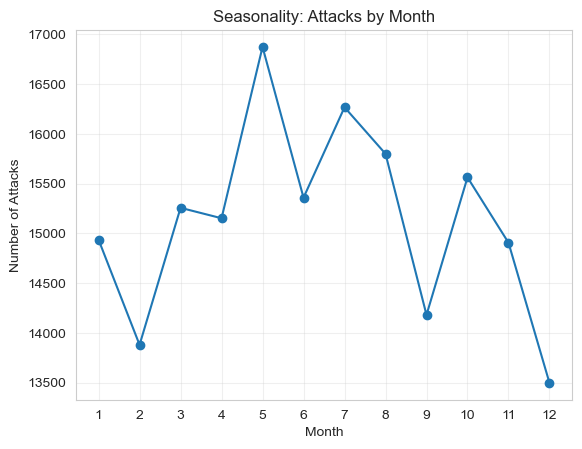

In [9]:
# Filter out missing months (coded as 0)
monthly = df[df['imonth'].between(1, 12)].groupby('imonth').size()
plt.figure()
monthly.plot(marker='o')
plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('Number of Attacks')
plt.title('Seasonality: Attacks by Month')
plt.grid(alpha=0.3)
plt.show()

### Top 25 Countries by Number of Attacks (Word Cloud)

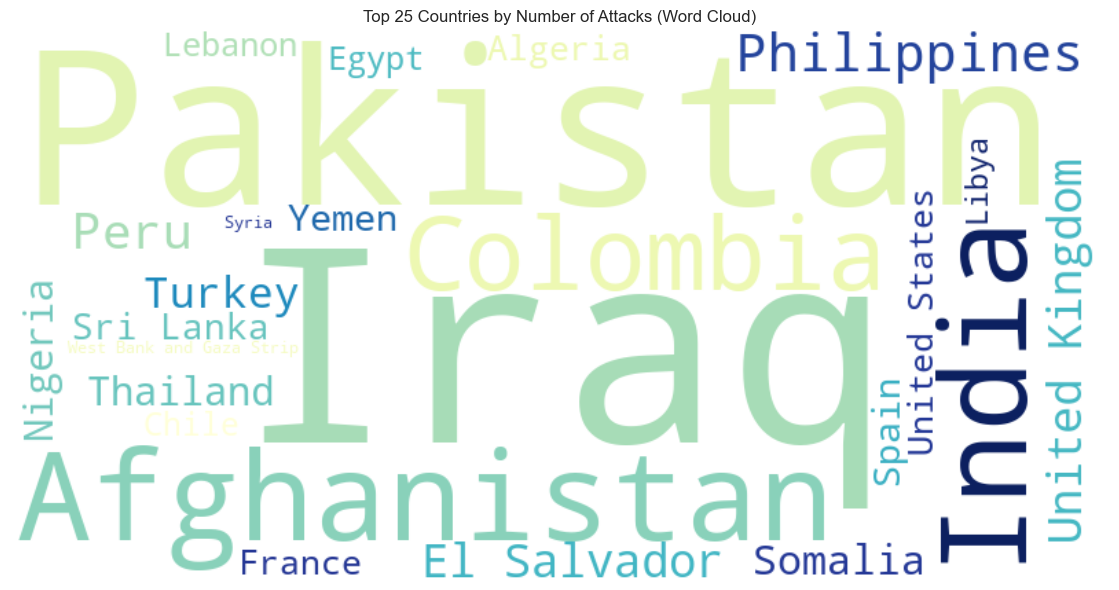

In [5]:
from wordcloud import WordCloud

freqs = df['country_txt'].value_counts().head(25).to_dict()
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=25,
    relative_scaling=0.5,  # flatten size differences a bit
    colormap='YlGnBu',  # a smoother, eye-friendly palette
).generate_from_frequencies(freqs)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Top 25 Countries by Number of Attacks (Word Cloud)')
plt.tight_layout()
plt.show()

### Terrorist Attacks per Year by Region

<Figure size 800x600 with 0 Axes>

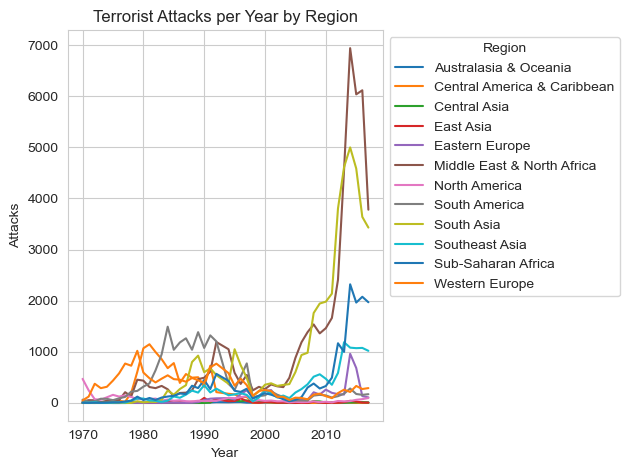

In [6]:
attacks_by_region = df.groupby(['region_txt', 'iyear']).size().unstack(fill_value=0)
plt.figure(figsize=(8, 6))
attacks_by_region.T.plot()
plt.title('Terrorist Attacks per Year by Region')
plt.xlabel('Year')
plt.ylabel('Attacks')
plt.legend(title='Region', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
# todo: looks terrible

### Global Terrorist Attacks by Country (Choropleth via Plotly)

In [13]:
import plotly.express as px

# Aggregate attack counts
attacks = df['country_txt'].value_counts().rename_axis('country').reset_index(name='attacks')

# Custom colorscale: white -> soft cream -> pale yellow -> orange -> red
custom_scale = [
    [0.0, "#ffffff"],  # white
    [0.005, "#fffaf0"],  # a soft off-white
    [0.1, "#fee8c8"],  # cream
    [0.3, "#fdd49e"],  # light orange
    [0.5, "#fdbb84"],  # richer orange
    [0.7, "#fc8d59"],  # salmon-orange
    [0.9, "#e34a33"],  # dark orange-red
    [1.0, "#b30000"]  # deep red
]

fig = px.choropleth(
    attacks,
    locations='country',
    locationmode='country names',
    color='attacks',
    color_continuous_scale=custom_scale,
    title='Global Terrorist Attacks by Country (1970–2017)',
    labels={'attacks': '# Attacks'},
    projection='natural earth',
    height=750,
)

fig.update_layout(
    margin={"r": 0, "t": 80, "l": 0, "b": 0},
    coloraxis_colorbar=dict(
        title='Attacks',
        thicknessmode='pixels', thickness=15,
        ticklen=3
    ),
    title={
        'text': 'Global Terrorist Attacks by Country (1970–2017)',
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.update_geos(
    showland=True, landcolor="white",
    showocean=True, oceancolor="lightblue",
    showcountries=True, countrycolor="white",
    showframe=True
)

fig.show()

### Top 10 Terrorist Groups by Number of Attacks

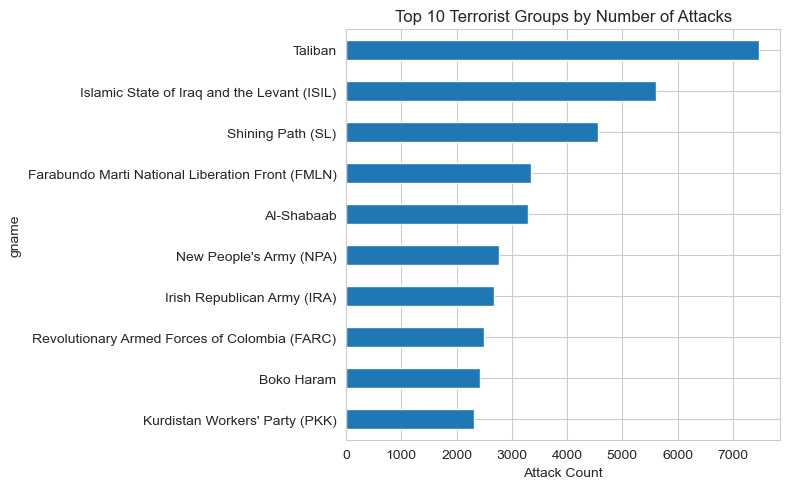

In [8]:
top_groups = df['gname'].value_counts().drop('Unknown').head(10)
plt.figure(figsize=(8, 5))
top_groups.plot(kind='barh')
plt.title('Top 10 Terrorist Groups by Number of Attacks')
plt.xlabel('Attack Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Attacks per Year for Top 5 Terrorist Groups

In [10]:
import plotly.express as px

# 1. Filter to top-5 groups (drop “Unknown”)
top5 = df['gname'].value_counts().drop('Unknown').head(5).index
df_top5 = df[df['gname'].isin(top5)]

# 2. Aggregate counts by group, year, and region
group_year = (
    df_top5
    .groupby(['gname', 'iyear', 'region_txt'])
    .size()
    .reset_index(name='count')
)

# 3. Bubble plot
fig = px.scatter(
    group_year,
    x='iyear',
    y='gname',
    size='count',
    color='region_txt',
    color_discrete_sequence=px.colors.qualitative.Safe,
    labels={
        'iyear': 'Year',
        'gname': 'Terrorist Group',
        'region_txt': 'Region',
        'count': '# Attacks'
    },
    height=600
)

# 4. Layout tweaks for title and legend
fig.update_layout(
    title={
        'text': 'Attacks Over Time & Region for Top 5 Terrorist Groups',
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    margin=dict(l=120, r=20, t=80, b=40),
    legend=dict(
        title='Region',
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

fig.update_xaxes(dtick=5)

fig.show()